# CITE-seq reference mapping with totalVI

With totalVI, we can train a reference model that can be used for mapping new query data. Here we dive into this functionality.

If you use totalVI, please consider citing:

* Gayoso, A., Steier, Z., Lopez, R., Regier, J., Nazor, K. L., Streets, A., & Yosef, N. (2021). Joint probabilistic modeling of single-cell multi-omic data with totalVI. Nature Methods, 18(3), 272-282.

In [ ]:
!pip install --quiet scvi-colab
import sys

from scvi_colab import install

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scrublet
    !pip install --upgrade numba
install()

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scrublet as scr
import scvi
import umap
from scvi.model import TOTALVI
from sklearn.ensemble import RandomForestClassifier

## Building a reference model

In [2]:
sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


This dataset was filtered as described in the scvi-tools manuscript (low quality cells, doublets, lowly expressed genes, etc.).

<div class="alert alert-info">

Note

Here we use the argument `mask_protein_batches=5`. What this does is treats the protein data in 5/24 of the batches in this dataset as missing. This will help totalVI integrate query data that has a subset of the proteins measured in this dataset or no proteins at all (i.e., just scRNA-seq data).

</div>

In [3]:
adata = scvi.data.pbmc_seurat_v4_cite_seq(
    mask_protein_batches=5,
)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

INFO     File data/pbmc_seurat_v4.h5ad already downloaded                                    


/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/scvi/data/_built_in_data/_cite_seq.py:156: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  protein_df[p] = adata.obsm["protein_counts"][p]
/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/scvi/data/_built_in_data/_cite_seq.py:156: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  protein_df[p] = adata.obsm["protein_counts"][p]
/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/scvi/data/_built_in_data/_cite_seq.py:156

In [4]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="orig.ident",
    subset=True,
    layer="counts",
)

In [5]:
adata

AnnData object with n_obs × n_vars = 152094 × 4000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Protein log library size', 'Number proteins detected', 'RNA log library size'
    var: 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    obsm: 'protein_counts'
    layers: 'counts'

In [6]:
TOTALVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="orig.ident",
    protein_expression_obsm_key="protein_counts",
)

INFO     Using column names from columns of adata.obsm['protein_counts']                     
INFO     Found batches with missing protein expression                                       


### Prepare and run model


Here we use the scArches-specific totalVI parameters, as shown in the scArches tutorial.

Rather than training the model here, which would take 1 hour, we instead download a pretrained object.

In [7]:
# # training code here
# arches_params = dict(
#     use_layer_norm="both",
#     use_batch_norm="none",
#     n_layers_decoder=2,
#     n_layers_encoder=2,
# )

# vae = TOTALVI(adata, **arches_params)
# vae.train(max_epochs=250)
# vae.save("seurat_reference_model", overwrite=True)

In [9]:
%%capture
!wget https://figshare.com/ndownloader/files/30929902 -O seurat_reference_model.zip
!unzip seurat_reference_model.zip

# Convert old model file to updated format. Only necessary for save files from <v0.15.0.
TOTALVI.convert_legacy_save("seurat_reference_model", "updated_seurat_reference_model")
vae = TOTALVI.load("updated_seurat_reference_model", adata=adata)

In [32]:
vae.view_anndata_setup()

Anndata setup with scvi-tools version 0.15.0b0.

Setup via `TOTALVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'orig.ident',
│   'labels_key': '_scvi_labels',
│   'protein_expression_obsm_key': 'protein_counts',
│   'protein_names_uns_key': '_protein_names'
}

     Summary Statistics      
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Summary Stat Key ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│     n_cells      │ 152094 │
│      n_vars      │  4000  │
│     n_batch      │   24   │
│     n_labels     │   1    │
│    n_proteins    │  217   │
└──────────────────┴────────┘

                 Data Registry                 
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃     scvi-tools Location      ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │    adata.layers['counts']    │
│    batch     │   adata.obs['_scvi_batch']   │
│    labels    │  adata.obs['_scvi_labels']   │
│   proteins   │ adata.obsm['protein_counts'] │
└──────────────┴──────────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['orig.ident'] │    P1_0    │          0          │
│                         │    P1_3    │          1          │
│                         │    P1_7    │          2          │
│                         │    P2_0    │          3          │
│                         │    P2_3    │          4          │
│                         │    P2_7    │          5          │
│                         │    P3_0    │          6          │
│                         │    P3_3    │          7          │
│                         │    P3_7    │          8          │
│                         │    P4_0    │          9          │
│                         │    P4_3    │         10          │
│                         │    P4_7    │         11          │
│                         │    P5_0    │         12          │
│                         │    P5_3    │         13          │
│                         │    P5_7    │         14          │
│                         │    P6_0    │         15          │
│                         │    P6_3    │         16          │
│                         │    P6_7    │         17          │
│                         │    P7_0    │         18          │
│                         │    P7_3    │         19          │
│                         │    P7_7    │         20          │
│                         │    P8_0    │         21          │
│                         │    P8_3    │         22          │
│                         │    P8_7    │         23          │
└─────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

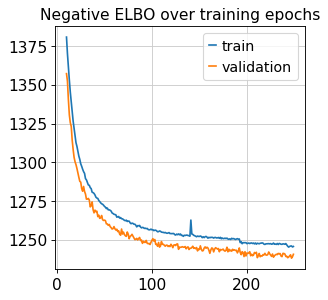

In [10]:
plt.plot(vae.history["elbo_train"].iloc[10:], label="train")
plt.plot(vae.history["elbo_validation"].iloc[10:], label="validation")
plt.title("Negative ELBO over training epochs")
plt.legend()

In [11]:
adata.obsm["X_totalvi_scarches"] = vae.get_latent_representation()

### Train a classifier on the latent space

The representation of the reference data will not change when the model gets updated with query data. Therefore, we can train any simple classifier on the latent space. Here we use a Random Forest from scikit-learn.

By storing the classifier object in our totalVI instance (and giving it an attribute that ends with `_`), we can automatically save and load this classifier along with our model.

In [12]:
y_train = adata.obs["celltype.l2"].astype("category").cat.codes.to_numpy()
X_train = adata.obsm["X_totalvi_scarches"]
clf = RandomForestClassifier(
    random_state=1,
    class_weight="balanced_subsample",
    verbose=1,
    n_jobs=-1,
)
clf.fit(X_train, y_train)

vae.latent_space_classifer_ = clf

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.6s finished


### Inspect reference model

We can view the latent space using UMAP and plot the study-derived cell type labels.

Here we use the umap API instead of scanpy so that we can later use the same umap object on the query data.

In [13]:
X = adata.obsm["X_totalvi_scarches"]
trans = umap.UMAP(
    n_neighbors=10,
    random_state=42,
    min_dist=0.4,
)
adata.obsm["X_umap"] = trans.fit_transform(X)

vae.umap_op_ = trans

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


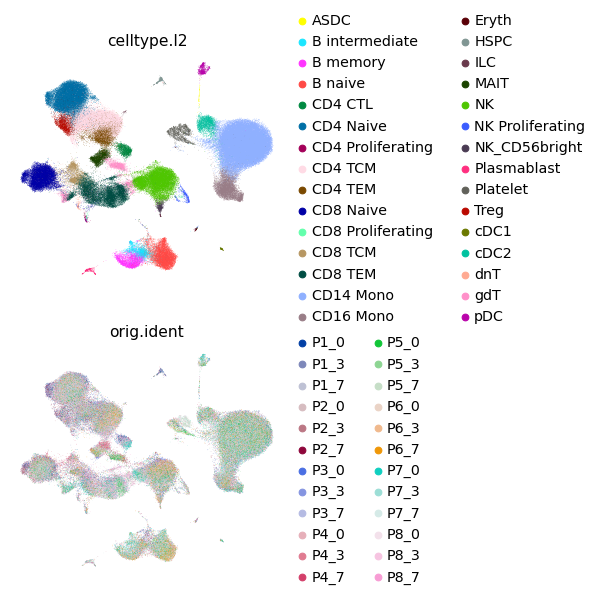

In [14]:
sc.pl.umap(
    adata,
    color=["celltype.l2", "orig.ident"],
    frameon=False,
    ncols=1,
)

## Map query data

Now we download our query data and cover the preprocessing necessary to map with our reference model.

In this case our query data are also PBMCs and come from the following study:

* Arunachalam, Prabhu S., et al. "Systems biological assessment of immunity to mild versus severe COVID-19 infection in humans." Science 369.6508 (2020): 1210-1220.

This dataset is also CITE-seq, but contains a subset of the proteins of the reference data.

In [15]:
query = sc.read(
    "data/covid_cite.h5ad", backup_url="https://ndownloader.figshare.com/files/27458837"
)

  0%|          | 0.00/289M [00:00<?, ?B/s]

### Preprocessing

First we remove any doublets from the query dataset using Scrublet. This has to be run per batch, which in this dataset is denoted with `"set"`.

In [19]:
query.obs["doublet_scores"] = 0
query.obs["predicted_doublets"] = True
for s in np.unique(query.obs["set"]):
    mask = query.obs["set"] == s
    counts_matrix = query[mask].X.copy()
    scrub = scr.Scrublet(counts_matrix)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    query.obs["doublet_scores"].iloc[mask] = doublet_scores
    query.obs["predicted_doublets"].iloc[mask] = predicted_doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 3.8%
Estimated detectable doublet fraction = 41.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.2%
Elapsed time: 68.2 seconds


/tmp/ipykernel_14976/4043290043.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query.obs["doublet_scores"].iloc[mask] = doublet_scores
/tmp/ipykernel_14976/4043290043.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query.obs["predicted_doublets"].iloc[mask] = predicted_doublets


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.23
Detected doublet rate = 6.6%
Estimated detectable doublet fraction = 57.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.4%
Elapsed time: 64.2 seconds


/tmp/ipykernel_14976/4043290043.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query.obs["predicted_doublets"].iloc[mask] = predicted_doublets


Next we do the following:

1. Store the counts in a layer, perform standard preprocessing
1. Add blank metadata that we will later fill in with predicted labels
1. Rename the batch key to correspond to the reference data
1. Add proteins with all 0 counts for the missing proteins in this query dataset

In [21]:
query.layers["counts"] = query.X.copy()
sc.pp.normalize_total(query, target_sum=1e4)
sc.pp.log1p(query)
query.raw = query
# subset to reference vars
query = query[:, adata.var_names].copy()

query.obsm["protein_counts"] = query.obsm["pro_exp"].copy()
query.obs["celltype.l2"] = "Unknown"
query.obs["orig.ident"] = query.obs["set"]
query.obsm["X_umap"] = query.obs[["UMAP1", "UMAP2"]]

# reorganize query proteins, missing proteins become all 0
for p in adata.obsm["protein_counts"].columns:
    if p not in query.obsm["protein_counts"].columns:
        query.obsm["protein_counts"][p] = 0.0
# ensure columns are in same order
query.obsm["protein_counts"] = query.obsm["protein_counts"].loc[
    :, adata.obsm["protein_counts"].columns
]

/tmp/ipykernel_14976/2379243673.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  query.obsm["protein_counts"][p] = 0.0
/tmp/ipykernel_14976/2379243673.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  query.obsm["protein_counts"][p] = 0.0
/tmp/ipykernel_14976/2379243673.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

For later visualization, we add some metadata to denote whether the dataset is reference of query

In [22]:
adata.obs["dataset_name"] = "Reference"
query.obs["dataset_name"] = "Query"

### Query model training

In [23]:
vae_q = TOTALVI.load_query_data(
    query,
    vae,
)
vae_q.train(
    max_epochs=150,
    plan_kwargs=dict(weight_decay=0.0, scale_adversarial_loss=0.0),
)

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


INFO     Found batches with missing protein expression                                       
INFO     Computing empirical prior initialization for protein background.                    


/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/scvi/model/_totalvi.py:133: UserWarning: Some proteins have all 0 counts in some batches. These proteins will be treated as missing measurements; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.
  warnings.warn(msg, UserWarning)
/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/scvi/model/base/_archesmixin.py:123: UserWarning: Query integration should be performed using models trained with version >= 0.8
  warnings.warn(
/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_

Epoch 1/150:   0%|          | 0/150 [00:00<?, ?it/s]

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:97: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/eecs/jjhong922/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1645690191318/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)


Epoch 150/150: 100%|██████████| 150/150 [19:01<00:00,  7.61s/it, loss=352, v_num=1]


And now we retrieve the latent representation for the query data

In [24]:
query.obsm["X_totalvi_scarches"] = vae_q.get_latent_representation(query)

### Query cell type prediction

We can use the random forest that we previously trained using the latent representation of the query data in the updated model!

In [25]:
# predict cell types of query
predictions = vae_q.latent_space_classifer_.predict(query.obsm["X_totalvi_scarches"])
categories = adata.obs["celltype.l2"].astype("category").cat.categories
cat_preds = [categories[i] for i in predictions]
query.obs["celltype.l2"] = cat_preds
query.obs["predicted_l2_scarches"] = cat_preds

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    1.2s finished


### Evaluate label transfer

Now we plot the predicted labels and the labels from the query study (here denoted as `"final_clust_review"`) on the UMAP coordinated used in the query study. We can see that we have an overall strong concordance, but also some important differences. For example, the study found a population of monocytes with interferon signaling, but as the reference contains no such cell type, it can only predict them to be CD14 monocytes.

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype.l2' as categorical
/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dataset_name' as categorical
/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categori

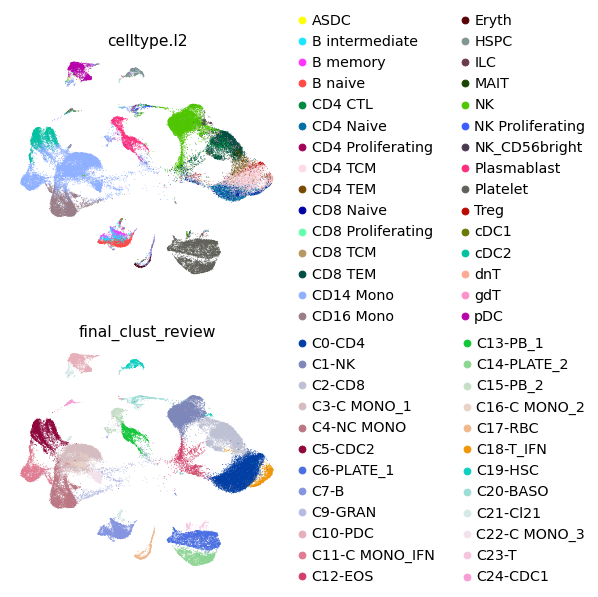

In [26]:
sc.pl.umap(
    query,
    color=["celltype.l2", "final_clust_review"],
    frameon=False,
    ncols=1,
)

### Use reference UMAP

We can also use the same UMAP operator from the reference step to visualize our query data.

In [27]:
query.obsm["X_umap_project"] = vae_q.umap_op_.transform(
    query.obsm["X_totalvi_scarches"]
)

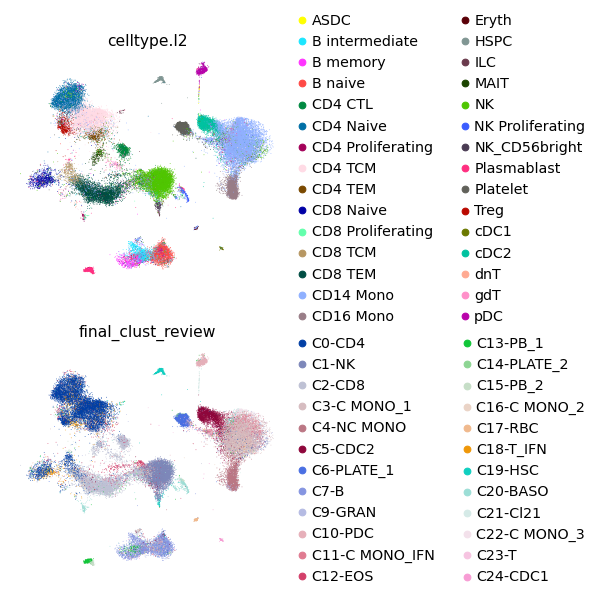

In [28]:
sc.pl.embedding(
    query,
    "X_umap_project",
    color=["celltype.l2", "final_clust_review"],
    frameon=False,
    ncols=1,
)

And finally we can combine the umaps together and visualize jointly.

In [29]:
umap_adata = sc.AnnData(
    np.concatenate(
        [
            query.obsm["X_umap_project"],
            adata.obsm["X_umap"],
        ],
        axis=0,
    )
)
umap_adata.obs["celltype"] = np.concatenate(
    [query.obs["celltype.l2"].values, adata.obs["celltype.l2"].values]
)
umap_adata.obs["dataset"] = np.concatenate(
    [query.shape[0] * ["query"], adata.shape[0] * ["reference"]]
)
umap_adata.obsm["X_umap"] = umap_adata.X

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical
/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True

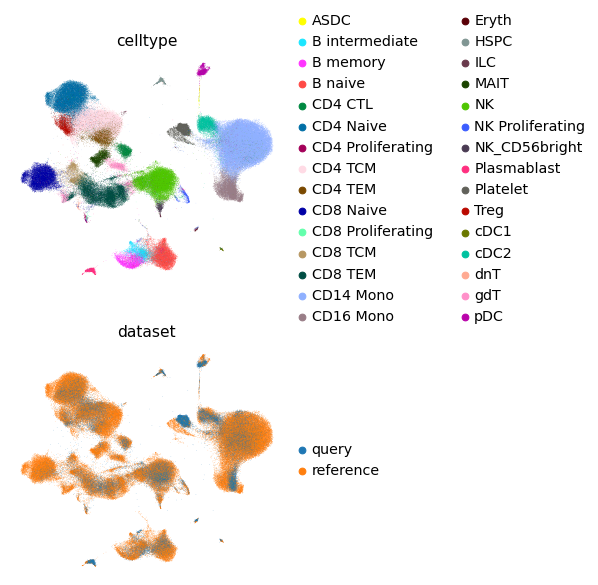

In [30]:
inds = np.random.permutation(np.arange(umap_adata.shape[0]))
sc.pl.umap(
    umap_adata[inds],
    color=["celltype", "dataset"],
    frameon=False,
    ncols=1,
)